Download and Extract the Food-101 Dataset. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Food\ Recognition

/content/drive/MyDrive/Food Recognition


In [ ]:
!unzip indiafood21categoriessmall.zip

Archive:  indiafood21categoriessmall.zip
  inflating: india_food_21_small/butter_chicken/00000000.jpg  
  inflating: india_food_21_small/butter_chicken/00000001.jpg  
  inflating: india_food_21_small/butter_chicken/00000002.jpg  
  inflating: india_food_21_small/butter_chicken/00000003.jpg  
  inflating: india_food_21_small/butter_chicken/00000004.jpg  
  inflating: india_food_21_small/butter_chicken/00000005.jpg  
  inflating: india_food_21_small/butter_chicken/00000006.jpg  
  inflating: india_food_21_small/butter_chicken/00000008.jpg  
  inflating: india_food_21_small/butter_chicken/00000009.jpg  
  inflating: india_food_21_small/butter_chicken/00000010.jpg  
  inflating: india_food_21_small/butter_chicken/00000011.jpg  
  inflating: india_food_21_small/butter_chicken/00000012.jpg  
  inflating: india_food_21_small/butter_chicken/00000014.jpg  
  inflating: india_food_21_small/butter_chicken/00000015.jpg  
  inflating: india_food_21_small/butter_chicken/00000016.jpg  
  inflating: i

In [ ]:
import os
path =r'images'
list_of_files = []

for root,dirs, files in os.walk(path):
	for file in files:
		list_of_files.append(os.path.join(root,file))
for name in list_of_files:
    na=str(name).replace("images/","")
    fin=na.replace(".jpg","")
    fin1=fin.replace(".JPG","")
    fin2=fin1.replace(".jpeg","")
    fin3=fin2.replace(".png","")
    print("fin=",fin2)
    f = open("meta/test.txt", "a")
    f.writelines("%s\n" % fin3)
    f.close()
print("success")


In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 
!tar xzvf food-101.tar.gz

Import the necessary modules. 

In [ ]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

%matplotlib inline

: 

Generating essential dictionaries and methods that will be make life simple.  

In [ ]:
class_N = {}
N_class = {}
with open('india_food_21_small/meta/classes.txt', 'r') as txt: 
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)
#how much food items it will represent with key values 

# Method to generate directory-file map. 
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
           
    return dir_files

# Method to recursively copy a directory.  
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore. 
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('india_food_21_small/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.    
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('india_food_21_small/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.  
def load_images(path_to_imgs):
  resize_count = 0
  
  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)
  
  return np.array(all_imgs), np.array(all_classes)

# Method to generate train-test files. 
def gen_train_test_split(path_to_imgs = 'india_food_21_small/images' , target_path = 'india_food_21_small'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test


{'butter_chicken': 0, 'butter_naan': 1, 'chicken_fried_rice': 2, 'chole_bhature': 3, 'dahi_bhalla': 4, 'dal_makhani': 5, 'gajar_halwa': 6, 'hilsa_fish_curry': 7, 'idli': 8, 'jalebi': 9, 'kachori': 10, 'kadai_paneer': 11, 'kulfi': 12, 'masala_dosa': 13, 'nalli_nihari': 14, 'pasta': 15, 'peda': 16, 'pizza': 17, 'rasgulla': 18, 'samosa': 19, 'vada_pav': 20}


In [ ]:
# Generate train-test files. 
if not os.path.isdir('./india_food_21_small/test') and not os.path.isdir('./india_food_21_small/train'):
    gen_train_test_split()  
    len_train = len(os.listdir('india_food_21_small/train'))
    len_test = len(os.listdir('india_food_21_small/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('india_food_21_small/train'))
    len_test = len(os.listdir('india_food_21_small/test'))
    print(len_train,len_test)

train and test folders already exists.
21 21


In [23]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('india_food_21_small/images'))
foods_sorted

['butter_chicken',
 'butter_naan',
 'chicken_fried_rice',
 'chole_bhature',
 'dahi_bhalla',
 'dal_makhani',
 'gajar_halwa',
 'hilsa_fish_curry',
 'idli',
 'jalebi',
 'kachori',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'nalli_nihari',
 'pasta',
 'peda',
 'pizza',
 'rasgulla',
 'samosa',
 'vada_pav']

(590, 759, 3)


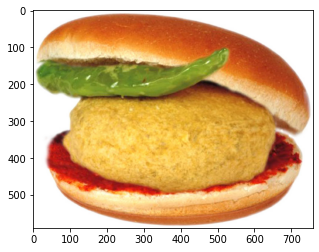

In [ ]:
# Display an image. Brb. Gtg and get a waffle for myself. :P
testImg = imread('india_food_21_small/test/vada_pav/00000028.jpg')
print(testImg.shape)
plt.imshow(testImg)

In [ ]:
X_train, y_train, X_test, y_test = load_train_test_data('india_food_21_small/train','india_food_21_small/test')

Fitting the data on the Inception-v3 model.

In [25]:
tensorflow.keras.backend.clear_session()

n_classes = 21
batch_size = 16
width, height = 200, 200
train_data = 'india_food_21_small/train'
test_data = 'india_food_21_small/test'
train_samples = 452
test_samples = 452

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_21class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_21class.log')

history_21class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=20, callbacks=[csv_logger, checkpointer])

model.save('model_trained_21class.hdf5')

Found 452 images belonging to 21 classes.
Found 452 images belonging to 21 classes.
Epoch 1/5
28/28 [==============================] - 46s 1s/step - loss: 3.4368 - accuracy: 0.0505 - val_loss: 3.8299 - val_accuracy: 0.0290
Epoch 2/5
28/28 [==============================] - 38s 1s/step - loss: 3.3431 - accuracy: 0.0596 - val_loss: 3.4683 - val_accuracy: 0.0513
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 3.2054 - accuracy: 0.0734 - val_loss: 3.2275 - val_accuracy: 0.0781
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 3.1558 - accuracy: 0.1009 - val_loss: 3.0653 - val_accuracy: 0.1429
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 3.0683 - accuracy: 0.1147 - val_loss: 2.9488 - val_accuracy: 0.1964


In [26]:
class_map_101 = train_gen.class_indices
class_map_101

{'butter_chicken': 0,
 'butter_naan': 1,
 'chicken_fried_rice': 2,
 'chole_bhature': 3,
 'dahi_bhalla': 4,
 'dal_makhani': 5,
 'gajar_halwa': 6,
 'hilsa_fish_curry': 7,
 'idli': 8,
 'jalebi': 9,
 'kachori': 10,
 'kadai_paneer': 11,
 'kulfi': 12,
 'masala_dosa': 13,
 'nalli_nihari': 14,
 'pasta': 15,
 'peda': 16,
 'pizza': 17,
 'rasgulla': 18,
 'samosa': 19,
 'vada_pav': 20}

NameError: ignored

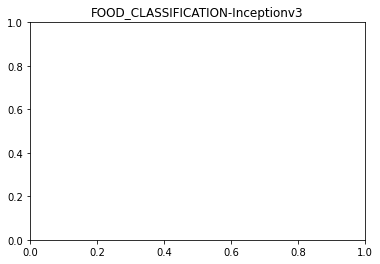

In [ ]:
# Plot training-accuracy & validation-accuracy.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_21class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_21class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

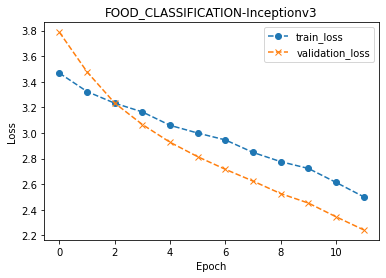

In [ ]:
# Plot training-loss & validation-loss.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_21class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_21class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

In [27]:
# Loading the best saved model to make predictions.
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_21class.hdf5',compile = False)
# Downloading some test images.


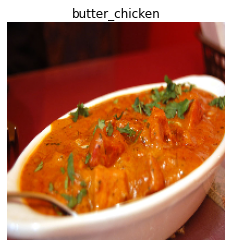

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(200, 200))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = img / 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = ['butter.jpg']
predict_class(model_best, images, True)

Let us try to dig a little bit deeper and demystify the network by displaying the activation layers, heat-map, class-activation-map of an image. 

In [ ]:
def deprocess_img(tensor):
    # normalize tensor, map between [0,1] & transform to RGB array
    tensor = tensor - tensor.mean()
    tensor = tensor / (tensor.std() + 1e-5)
    tensor = tensor * 0.1
    tensor = tensor + 0.5
    tensor = np.clip(tensor, 0, 1)
    tensor = tensor * 255
    tensor = np.clip(tensor, 0, 255).astype('uint8')
    return tensor

def gen_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = tensorflow.keras.backend.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    gradient = tensorflow.keras.backend.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    gradient = gradient / (tensorflow.keras.backend.sqrt(tensorflow.keras.backend.mean(tensorflow.keras.backend.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = tensorflow.keras.backend.function([model.input], [loss, gradient])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, gradients_value = iterate([input_img_data])
        ip_img_data += gradients_value * step
        
    img = ip_img_data[0]
    return deprocess_img(img)

def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255. 
    #plt.imshow(img[0])
    #plt.show()
    return model_activations.predict(img)

def show_activations(activations, layers):
    imgs_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_act in zip(layers, activations):
        # This is the number of features in the feature map
        n_feats = layer_act.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_act.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_feats // imgs_per_row
        show_grid = np.zeros((size * n_cols, imgs_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(imgs_per_row):
                channel_img = layer_act[0, :, :, col * imgs_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_img = channel_img - channel_img.mean()
                channel_img = channel_img / channel_img.std()
                channel_img = channel_img * 64
                channel_img = channel_img + 128
                channel_img = np.clip(channel_img, 0, 255).astype('uint8')
                show_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_img

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * show_grid.shape[1], scale * show_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(show_grid, aspect='auto', cmap='viridis')

    plt.show()  

# Method to display the Heatmap and Class Activation of an image. 
def get_attribution(food):
    img = image.load_img(food, target_size=(200, 200))
    img = image.img_to_array(img) 
    img = img / 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0) 
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = tensorflow.keras.backend.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = tensorflow.keras.backend.mean(grads, axis=(0, 1, 2))
    iterate = tensorflow.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    
    for i in range(2048):
        conv_layer_output_value[:, :, i] = conv_layer_output_value[:, :, i] * pooled_grads_value[i]
        heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heatmap")
    
    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.7, heatmap, 0.3, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(200, 200))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation Map")
    plt.show()
    return preds  


In [ ]:
tensorflow.keras.backend.clear_session()
print("Loading the model..")
model = load_model('best_model_21class.hdf5',compile = False)
# Get model layers
layers = [layer.output for layer in model.layers[1:11]]
layer_names = []

activations_output = models.Model(inputs=model.input, outputs=layers)

for layer in model.layers[1:11]:
    layer_names.append(layer.name)

print(layer_names)
print(len(model.layers))

Loading the model..
['conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d']
315


RuntimeError: ignored

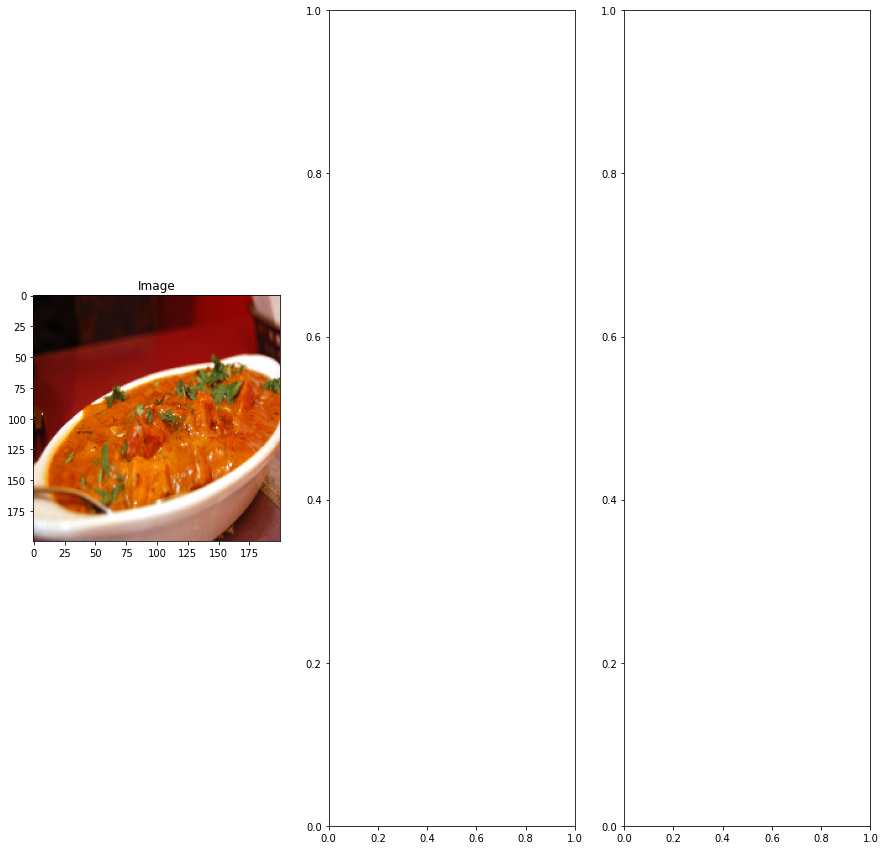

In [ ]:
# Get attributions
get_attribution('butter.jpg')
# Show activation layers
show_activations(get_activations('butter.jpg',activations_output), layer_names)

In [ ]:
!pip install json

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [ ]:
import json
from nutritionix import Nutritionix
nix = Nutritionix(app_id="b09e5694", api_key="35c5996f52ebded16b21f6de76393aff")
data=nix.search('dosa', results="0:1").json()


In [ ]:
for key in data['hits']:
     print (key['_id'])

5938082bd9b43e1547ab1c1d


In [ ]:
dict1=nix.item(id=key['_id']).json()
out_file = open("myfile.json", "w")     
json.dump(dict1, out_file, indent = 6)     
out_file.close() 

In [ ]:
import requests
import pandas as pd


def get_nutrition(food_name):
    nutrition_data = pd.DataFrame(columns=['name', 'protein', 'calcium', 'fat', 'carbohydrates', 'vitamins'])
    for name in food_name:
        url = "https://api.nal.usda.gov/fdc/v1/foods/search?api_key=d4D6dSOc81pTAOY2gsNZ0YhjkMlhStLJRoII5SJu&query=" + name
        response = requests.get(url)
        data = response.json()
        flatten_json = pd.json_normalize(data["foods"])
        first_food = flatten_json.iloc[0]
        first_food_nutrition_list = first_food.foodNutrients
        for item in first_food_nutrition_list:
            if item['nutrientNumber'] == "203":
                protein = item['value']
                continue
            if item['nutrientNumber'] == "301":
                calcium = item['value']
                continue
            if item['nutrientNumber'] == "204":
                fat = item['value']
                continue
            if item['nutrientNumber'] == "205":
                carbs = item['value']
                continue
                '''
            if item['nutrientNumber'] == "318":
                vitamin_a = item['value']
                continue
            if item['nutrientNumber'] == "401":
                vitamin_c = item['value']
                continue
        vitamins = float(vitamin_a) + float(vitamin_c)
        '''
        print(name)
        nutrition_data = nutrition_data.append({
            'name': name,
            'protein': protein,
            'calcium': calcium / 1000,
            'fat': fat,
            'carbohydrates': carbs,
            
        }, ignore_index=True)

    return nutrition_data


nutrition101 = get_nutrition(['butter chicken',
         'butter naan',
         'chicken fried rice',
         'chole bhature',
         'dahi bhalla',
         'dal makhani',
         'gajar halwa',
         'hilsa fish curry',
         'idli',
         'kadai paneer',
         'kulfi',
         'masala dosa',
         'nalli nihari',
         'pasta',
         'pizza',
         'samosa',
         'vada pav']
                             )
nutrition101 = nutrition101.reset_index(drop=False)
nutrition101.to_csv("nutrition101.csv")


In [ ]:
import pandas as pd
df = pd.read_csv('nutrition21.csv')
# If you know the name of the column skip this
first_column = df.columns[1]
# Delete first
df = df.drop([first_column], axis=1)
df.to_csv('nutrition21.csv', index=False)

In [ ]:
import requests
import pandas as pd
import time


def get_nutrition(food_name):
    nutrition_data = pd.DataFrame(columns=['name', 'protein', 'calcium', 'fat', 'carbohydrates', 'vitamina','vitaminc'])
    for name in food_name:
        e = Edamam(nutrition_appid='ff1b4628',
           nutrition_appkey='ec127730626f8af847b898534a8664a8',
           recipes_appid='58390069',
           recipes_appkey='814c18df9377710ce8499838a4c5296f',
           food_appid='9030536a',
           food_appkey='b30e0439ecc796b76ae4be6b5af7e50b')
        
        response = e.search_recipe(name)
        for item in response['hits']:
            protien=item['recipe']['totalNutrients']['PROCNT']
            calcium=item['recipe']['totalNutrients']['CA']
            fat=item['recipe']['totalNutrients']['FAT']
            carbs=item['recipe']['totalNutrients']['CHOCDF']
            vitamina=item['recipe']['totalNutrients']['VITA_RAE']
            vitaminc=item['recipe']['totalNutrients']['VITC']
            energy=item['recipe']['totalNutrients']['ENERC_KCAL']
            time.sleep(10)
            break
        protien1=protien.get('quantity')
        calcium1=calcium.get('quantity')
        fat1=fat.get('quantity')
        carbs1=carbs.get('quantity')
        vitamina1=vitamina.get('quantity')
        vitaminc1=vitaminc.get('quantity')
        energy1=energy.get('quantity')

        print(name)
        nutrition_data = nutrition_data.append({
            'name': name,
            'protein': protien1,
            'calcium': calcium1,
            'fat': fat1,
            'carbohydrates': carbs1,
            'vitamina':vitamina1,
            'vitaminc': vitaminc1,
            'calories':energy1,
        }, ignore_index=True)

    return nutrition_data


nutrition101 = get_nutrition(['butter chicken',
         'butter naan',
         'chicken fried rice',
         'chole bhature',
         'dahi bhalla',
         'dal makhani',
         'gajar halwa',
         'hilsa fish curry',
         'idli',
         'jalebi',
         'kachori',
         'kadai paneer',
         'kulfi',
         'masala dosa',
         'nalli nihari',
         'pasta',
         'peda',
         'pizza',
         'rasgulla',
         'bomabay biriyani',
         'sabudana vada',
         'pesara dosa',
         'pasanda',
         'aloo tikka',
         'kadai paneer',
         'Uttapam',
         'Medu vada',
         'Mysore pak',
         'samosa',
         'Curd Rice',
         'Aloo paratha',
         'Shrikhand',
         'Kaju katli',
         'Jeera Rice',
         ' Coconut Chutney',
         'Dhokla',
         'Bhakri',
         'Laal maas',
         'Muthia',
         'Phirni',
         'Aluchya Wadya',
         'Gajar ka halwa',
         'Punjabi kadhi',
         'Malai kofta',
         'Kulcha',
         'Madras Curry',
         'Kachori',
         'Bonda',
         'Dal tadka',
         'Putu mayam',
         'Misal pav',
         'Bhelpuri',
         'Saag paneer',
         'Rajma',
         'Rasam',
         'Papadum',
         'Raita',
         'Laddu',
         'Jalfrezi',
         'Puri',
         'Falooda',
         'Khaja',
         'Shahi paneer',
         'Modak',
         'Barfi',
         'Rogan josh',
         'Kadhi',
         'Ras malai',
         'Nihari',
         'Pongal',
         'Misal',
         'Chicken 65',
         'Pakora',
         'Keema',
         'Pulihora',
         'Upma',
         'Khichdi',
         'Pav bhaji',
         'Palak paneer',
         'Gulab jamun',
         'Sambar',
         'Vindaloo',
         'Hyderabadi biryani',
         'Panipuri',
         'Chaat',
         'Appam'
        
         ]
                             )
#nutrition101 = nutrition101.reset_index(drop=False)
nutrition101.to_csv("nutrition.csv",index=False)


butter chicken
butter naan
chicken fried rice
chole bhature
dahi bhalla
dal makhani
gajar halwa
hilsa fish curry
idli
deepa
kadai paneer
kulfi
masala dosa
nalli nihari
pasta
pizza
samosa
vada pav

In [ ]:
!pip install flask-ngrok && pip install py_edamam

  Created wheel for py-edamam: filename=py_edamam-0.2-py3-none-any.whl size=3656 sha256=de284bb4690629dcdf197e8f7fc60b4df44ae714d90f593f0c0d473acded90b6
  Stored in directory: /root/.cache/pip/wheels/96/ca/6f/fb818d107cad3318057e9ed5bd4906ee7472d07c8e50767855
Successfully built py-edamam


In [1]:
import tensorflow
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok 
import csv
import math
import pandas as pd
from py_edamam import Edamam
import json
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import load_model
from werkzeug.utils import secure_filename
from pandas import *
tmpl_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'templates')
app = Flask(__name__, template_folder=tmpl_dir)
run_with_ngrok(app)
UPLOAD_FOLDER = 'static/uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# define label meaning
label = ['butter chicken',
         'butter naan',
         'chicken fried rice',
         'chole bhature',
         'dahi bhalla',
         'dal makhani',
         'gajar halwa',
         'hilsa fish curry',
         'idli',
         'jalebi',
         'kachori',
         'kadai paneer',
         'kulfi',
         'masala dosa',
         'nalli nihari',
         'pasta',
         'peda',
         'pizza',
         'rasgulla',
         'samosa']

nu_link = 'https://www.nutritionix.com/food/'

# Loading the best saved model to make predictions.
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_21class.hdf5', compile=False)
print('model successfully loaded!')

start = [0]
passed = [0]
pack = [[]]
num = [0]

nutrients = [
    {'name': 'protein', 'value': 0.0},
    {'name': 'calcium', 'value': 0.0},
    {'name': 'fat', 'value': 0.0},
    {'name': 'carbohydrates', 'value': 0.0},
    #{'name': 'vitamina', 'value': 0.0},
    #{'name': 'vitaminc', 'value': 0.0},
    
]

with open('nutrition21.csv', 'r') as file:
    reader = csv.reader(file)
    nutrition_table = dict()
    for i, row in enumerate(reader):
        if i == 0:
            name = ''
            continue
        else:
            name = row[0].strip()
        nutrition_table[name] = [
            {'name': 'protein', 'value': float(row[1])},
            {'name': 'calcium', 'value': float(row[2])},
            {'name': 'fat', 'value': float(row[3])},
            {'name': 'carbohydrates', 'value': float(row[4])},
            #{'name': 'vitamina', 'value': float(row[6])},
            #{'name': 'vitaminc', 'value': float(row[7])}
            
        ]


@app.route('/')
def index():
    img = 'static/profile.jpg'
    return render_template('index.html', img=img)


@app.route('/recognize')
def magic():
    return render_template('recognize.html', img=file)

@app.route('/predict',methods=['POST'])
def predict():
    file = request.files.getlist("img")
    for f in file:
        filename = secure_filename(str(num[0] + 500) + '.jpg')
        num[0] += 1
        name = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        print('save name', name)
        f.save(name)

    pack[0] = []
    result = []
    # pack = []
    print('total image', num[0])
    for i in range(start[0], num[0]):
        pa = dict()

        filename = f'{UPLOAD_FOLDER}/{i + 500}.jpg'
        print('image filepath', filename)
        pred_img = filename
        pred_img = image.load_img(pred_img, target_size=(200, 200))
        pred_img = image.img_to_array(pred_img)
        pred_img = np.expand_dims(pred_img, axis=0)
        pred_img = pred_img / 255.

        pred = model_best.predict(pred_img)
        print("Pred")
        print(pred)

        if math.isnan(pred[0][0]) and math.isnan(pred[0][1]) and \
                math.isnan(pred[0][2]) and math.isnan(pred[0][3]):
            pred = np.array([0.05, 0.05, 0.05, 0.07, 0.09, 0.19, 0.55, 0.0, 0.0, 0.0, 0.0])

        top = pred.argsort()[0][-3:]
        label.sort()
        _true = label[top[2]]
        pa['image'] = f'{UPLOAD_FOLDER}/{i + 500}.jpg'
        x = dict()
        x[_true] = float("{:.2f}".format(pred[0][top[2]] * 100))
        x[label[top[1]]] = float("{:.2f}".format(pred[0][top[1]] * 100))
        x[label[top[0]]] = float("{:.2f}".format(pred[0][top[0]] * 100))
        pa['result'] = x
        pa['nutrition'] = nutrition_table[_true]
        pa['food'] = f'{nu_link}{_true}'
        pa['idx'] = i - start[0]
        pa['quantity'] = 100

        pack[0].append(pa)
        passed[0] += 1

    start[0] = passed[0]
    print('successfully packed')
    # compute the average source of calories
    for p in pack[0]:
        nutrients[0]['value'] = (nutrients[0]['value'] + p['nutrition'][0]['value'])
        nutrients[1]['value'] = (nutrients[1]['value'] + p['nutrition'][1]['value'])
        nutrients[2]['value'] = (nutrients[2]['value'] + p['nutrition'][2]['value'])
        nutrients[3]['value'] = (nutrients[3]['value'] + p['nutrition'][3]['value'])
        

    nutrients[0]['value'] = nutrients[0]['value'] / num[0]
    nutrients[1]['value'] = nutrients[1]['value'] / num[0]
    nutrients[2]['value'] = nutrients[2]['value'] / num[0]
    nutrients[3]['value'] = nutrients[3]['value'] / num[0]
    for key,value in pa['result'].items():
        print (key)
        break
    e = Edamam(nutrition_appid='ff1b4628',
           nutrition_appkey='ec127730626f8af847b898534a8664a8',
           recipes_appid='58390069',
           recipes_appkey='814c18df9377710ce8499838a4c5296f',
           food_appid='9030536a',
           food_appkey='b30e0439ecc796b76ae4be6b5af7e50b')
          
   
    data=e.search_recipe(key)     
    for key in data['hits']:
        val=key['recipe']['ingredientLines']
        break
    for key in data['hits']:
        url=key['recipe']['url']
        enerrgy=key['recipe']['totalNutrients']['ENERC_KCAL']
        fat=key['recipe']['totalNutrients']['FAT']
        sat=key['recipe']['totalNutrients']['FASAT']
        mon=key['recipe']['totalNutrients']['FAMS']
        pol=key['recipe']['totalNutrients']['FAPU']
        carbs=key['recipe']['totalNutrients']['CHOCDF']
        fiber=key['recipe']['totalNutrients']['FIBTG']
        sugar=key['recipe']['totalNutrients']['SUGAR']
        #sugar_added=key['recipe']['totalNutrients']['SUGAR.added']
        protien=key['recipe']['totalNutrients']['PROCNT']
        chole=key['recipe']['totalNutrients']['CHOLE']
        break
    energy=f"{enerrgy.get('label')}={str(round(enerrgy.get('quantity')))+enerrgy.get('unit')}"
    fat1=f"{fat.get('label')}={str(round(fat.get('quantity')))+fat.get('unit')}"
    sat1=f"{sat.get('label')}={str(round(sat.get('quantity')))+sat.get('unit')}"
    mon1=f"{mon.get('label')}={str(round(mon.get('quantity')))+mon.get('unit')}"
    pol1=f"{pol.get('label')}={str(round(pol.get('quantity')))+pol.get('unit')}"
    crabs1=f"{carbs.get('label')}={str(round(carbs.get('quantity')))+carbs.get('unit')}"
    fiber1=f"{fiber.get('label')}={str(round(fiber.get('quantity')))+fiber.get('unit')}"
    suagr1=f"{sugar.get('label')}={str(round(sugar.get('quantity')))+sugar.get('unit')}"
    #sugaradded=f"{sugar_added.get('label')}={str(round(sugar_added.get('quantity')))+sugar_added.get('unit')}"
    prot=f"{protien.get('label')}={str(round(protien.get('quantity')))+protien.get('unit')}"
    chole1=f"{chole.get('label')}={str(round(chole.get('quantity')))+chole.get('unit')}"
    return render_template('results.html', pack=pack[0], whole_nutrition=nutrients,val=val,fat=fat1,sat=sat1,mon=mon1,pol=pol1,carbs=crabs1,fiber=fiber1,sugar=suagr1,prot=prot,chole=chole1,energy=energy,url=url)


@app.route('/diet')
def diet():
    
    return render_template('diet.html')
@app.route('/get-text', methods=['POST'])
def calculate():
    gen=request.form['gender']
    age=request.form['age']
    weight=request.form['weight']
    height=request.form['height']
    activity=request.form['activity_level']
    print(activity)
    diet_plan=request.form['diet_plan']
    print("type",type(diet_plan))
    if gen=="female":
        bmr=float(655) + 9.6 * float(weight) + 1.8 * float(height) - 4.7 * float(age)
        print(bmr)
    else:
        bmr=float(66) + 13.7 * float(weight) + 5 * float(height) - 6.8 * float(age)
    maintenance =float(bmr) * float(activity)
    loseWeight = int(maintenance) - 450;
    gainWeight = int(maintenance) + 450;
    base=f"Your Basal Metabolic Rate is  {round(bmr)} calories"
    main=f"To maintain your weight, you need to consume on average {round(maintenance)} calories"
    lose=f"To loose weight, you need to consume on average {round(loseWeight)} calories"
    gain=f"To gain weight, you need to consume on average {round(gainWeight)} calories"
    
    base_rec=round(bmr)
    #base_res = ', '.join(map(str, base_rec))
    main_rec=round(maintenance)
    #main_res=', '.join(map(str, main_rec))
    lose_rec=round(loseWeight)
    #gain_res=', '.join(map(str, gain_rec))
    gain_rec=round(gainWeight)
    #lose_res=', '.join(map(str, lose_rec))
    
    if diet_plan == "0":
        num=[lose_rec]
        print("loose 0")
    else:
        num=[gain_rec]
        print("gain 1")
    print("num",num)
    percents=[0.25,0.40,0.35]
    cal=[item * percent for item in num[0:] for percent in percents]
    breakf=Breakfast(cal[0])
    print("breakfast",breakf)
    lunc=lunch(cal[1])
    print("lunch",lunc)
    dinne=dinner(cal[2])
    print("Dinner",dinne)

    return render_template('diet.html',base=base,main=main,lose=lose,gain=gain,breakfast=breakf,lun=lunc,dinn=dinne)
@app.route('/recommend', methods=['POST'])
def closest(lst, K):
      return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
def Breakfast(cal):
    data=read_csv('Breakfast.csv')
    lst=data['Kcal'].tolist()
    K=int(cal)
    print("k=",K)
    calorie=int(closest(lst, K))
    print(calorie)
    csv_file = csv.reader(open('Breakfast.csv', "r"), delimiter=",")

    for row in csv_file:
        if str(calorie) == row[2]:
            Type=row[0]
            name=row[1]
            calo=row[2]
            return Type,name,calo
def dinner(cal):
    data=read_csv('Dinner.csv')
    lst=data['Kcal'].tolist()
    K=int(cal)
    print("k=",K)
    calorie=int(closest(lst, K))
    print(calorie)
    csv_file = csv.reader(open('Dinner.csv', "r"), delimiter=",")

    for row in csv_file:
        if str(calorie) == row[2]:
            Type=row[0]
            name=row[1]
            calo=row[2]
            return Type,name,calo
def lunch(cal):
    data=read_csv('Lunch.csv')
    lst=data['Kcal'].tolist()
    K=int(cal)
    print("k=",K)
    calorie=int(closest(lst, K))
    print(calorie)
    csv_file = csv.reader(open('Lunch.csv', "r"), delimiter=",")

    for row in csv_file:
        if str(calorie) == row[2]:
            Type=row[0]
            name=row[1]
            calo=row[2]
            return Type,name,calo
if __name__ == "__main__":
    import click

    
    def run():
        """
        This function handles command line parameters.
        Run the server using
            python server.py
        Show the help text using
            python server.py --help
        """
  
        app.run()
    run()


model successfully loaded!
 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [03/Feb/2023 12:02:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Feb/2023 12:02:04] "GET /static/profile.jpg HTTP/1.1" 304 -
127.0.0.1 - - [03/Feb/2023 12:02:04] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [03/Feb/2023 12:02:16] "GET /recognize HTTP/1.1" 200 -


In [ ]:
from pandas import *
import csv
def closest(lst, K):
      return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
def Breakfast(cal):
    data=read_csv('Dinner.csv')
    lst=data['Kcal'].tolist()
    print(lst)
    K=int(cal)
    print(K)
    calorie=int(closest(lst, K))
    print(calorie)
    csv_file = csv.reader(open('Dinner.csv', "r"), delimiter=",")
    for row in csv_file:
        if str(calorie) == row[2]:
            Type=row[0]
            name=row[1]
            calo=row[2]
            return Type,name,calo

num=[1000]
percents=[0.25,0.40,0.35]
cal=[item * percent for item in num[0:] for percent in percents]
breakf=Breakfast(cal[0])
print("lunch",breakf)
lunch=cal[1]
dinner=cal[2]

[120, 140, 60, 75, 150, 150, 150, 150, 100, 150, 175, 100, 40, 75, 30, 75, 100, 282, 233, 300, 420, 326, 183, 180, 167, 114, 140, 138, 171, 192, 44, 180, 130, 635, 160, 280, 325, 207, 246, 241, 311, 153, 290, 120, 73, 300, 163, 343, 240, 175, 266, 266, 180, 59, 280, 83, 109, 208, 330, 103, 155, 297, 254, 295, 793, 138, 182, 52, 144, 236, 280, 225, 233, 52, 270, 150]
250
246
lunch ('Dinner', 'Jeera Rice', '246')


In [ ]:
number=0
if number == 1:
    print(0)
else:
    print(1)

1


In [ ]:
num=[1554]
percents=[0.25,0.40,0.35]
cal=[item * percent for item in num[0:] for percent in percents]
cal[0]
print(num)

[1554]


Match Recipes to Daily Calories
Search Menu Items
Get Recipe Ingredients by id


In [ ]:
pip install py_edamam

  Created wheel for py-edamam: filename=py_edamam-0.2-cp37-none-any.whl size=3654 sha256=525409f9232e72a7c102f171160dcbe3077bbf5367fc70aa3490d6efcc9fad5c
  Stored in directory: /root/.cache/pip/wheels/8d/39/9f/420cf81a82bb729ea990e925155a8df75fe248668766a49da4
Successfully built py-edamam


In [ ]:
from py_edamam import Edamam
import json
e = Edamam(nutrition_appid='ff1b4628',
           nutrition_appkey='ec127730626f8af847b898534a8664a8',
           recipes_appid='58390069',
           recipes_appkey='814c18df9377710ce8499838a4c5296f',
           food_appid='9030536a',
           food_appkey='b30e0439ecc796b76ae4be6b5af7e50b')
           
           
#e.search_recipe("2000 calories")

#print(e.search_recipe("idli"))
#print(e.search_food("dosa"))
data=e.search_recipe("idli")
for key in data['hits']:
    enerrgy=key['recipe']['totalNutrients']['ENERC_KCAL']
    energy=f"{int(enerrgy.get('quantity'))}"
    print(energy)
    

1463
1865
889
1437
2979
955
1597
1668
1398
726


In [ ]:
from py_edamam import Edamam
import json
e = Edamam(nutrition_appid='ff1b4628',
           nutrition_appkey='ec127730626f8af847b898534a8664a8',
           recipes_appid='58390069',
           recipes_appkey='814c18df9377710ce8499838a4c5296f',
           food_appid='9030536a',
           food_appkey='b30e0439ecc796b76ae4be6b5af7e50b')
             
data=e.search_recipe("jalebi")
    
for key in data['hits']:
    url=key['recipe']['url']
    enerrgy=key['recipe']['totalNutrients']['ENERC_KCAL']
    fat=key['recipe']['totalNutrients']['FAT']
    sat=key['recipe']['totalNutrients']['FASAT']
    mon=key['recipe']['totalNutrients']['FAMS']
    pol=key['recipe']['totalNutrients']['FAPU']
    carbs=key['recipe']['totalNutrients']['CHOCDF']
    fiber=key['recipe']['totalNutrients']['FIBTG']
    sugar=key['recipe']['totalNutrients']['SUGAR']
    #sugar_added=key['recipe']['totalNutrients']['SUGAR.added']
    protien=key['recipe']['totalNutrients']['PROCNT']
    chole=key['recipe']['totalNutrients']['CHOLE']
    break
print(url)
print(f"{enerrgy.get('label')}={str(round(enerrgy.get('quantity')))+enerrgy.get('unit')}")
print(f"{fat.get('label')}={str(round(fat.get('quantity')))+fat.get('unit')}")
print(f"{sat.get('label')}={str(round(sat.get('quantity')))+sat.get('unit')}")
print(f"{mon.get('label')}={str(round(mon.get('quantity')))+mon.get('unit')}")
print(f"{pol.get('label')}={str(round(pol.get('quantity')))+pol.get('unit')}")
print(f"{carbs.get('label')}={str(round(carbs.get('quantity')))+carbs.get('unit')}")
print(f"{fiber.get('label')}={str(round(fiber.get('quantity')))+fiber.get('unit')}")
print(f"{sugar.get('label')}={str(round(sugar.get('quantity')))+sugar.get('unit')}")
#print(f"{sugar_added.get('label')}={str(round(sugar_added.get('quantity')))+sugar_added.get('unit')}")
print(f"{protien.get('label')}={str(round(protien.get('quantity')))+protien.get('unit')}")
print(f"{chole.get('label')}={str(round(chole.get('quantity')))+chole.get('unit')}")




https://www.epicurious.com/recipes/food/views/jalebi-366136
Energy=3342kcal
Fat=135g
Saturated=83g
Monounsaturated=39g
Polyunsaturated=6g
Carbs=524g
Fiber=7g
Sugars=341g
Protein=23g
Cholesterol=341mg


In [ ]:
from flask import Flask,request, render_template
from flask_ngrok import run_with_ngrok
import math
from py_edamam import Edamam
import pandas as pd
app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def home():

	return render_template('diet.html')
@app.route('/get-text', methods=['POST'])
def calculate():
    gen=request.form['gender']
    age=request.form['age']
    weight=request.form['weight']
    height=request.form['height']
    activity=request.form['activity_level']
    if gen=="female":
        bmr=float(655) + 9.6 * float(weight) + 1.8 * float(height) - 4.7 * float(age)
        print(bmr)
    else:
        bmr=float(66) + 13.7 * float(weight) + 5 * float(height) - 6.8 * float(age)
    maintenance =float(bmr) * float(activity)
    loseWeight = int(maintenance) - 450;
    gainWeight = int(maintenance) + 450;
    base=f"Your Basal Metabolic Rate is  {round(bmr)} calories"
    main=f"To maintain your weight, you need to consume on average {round(maintenance)} calories"
    lose=f"To loose weight, you need to consume on average {round(loseWeight)} calories"
    gain=f"To gain weight, you need to consume on average {round(gainWeight)} calories"
    base_rec=recommend(round(bmr))
    
    base_res=', '.join(map(str, base_rec))
    main_rec=recommend(round(maintenance))
    main_res=', '.join(map(str, main_rec))
    gain_rec=recommend(round(loseWeight))
    gain_res=', '.join(map(str, gain_rec))
    lose_rec=recommend(round(gainWeight))
    lose_res=', '.join(map(str, lose_rec))
    
    return render_template('diet.html',base=base,main=main,lose=lose,gain=gain,base_rec=base_res,main_rec=main_res,lose_rec=lose_res,gain_rec=gain_res)
def recommend(rec):
      global enerrgy,fat
      df=pd.read_csv("nutrition21.csv")
      f1=df.sample(1)
      name=f1['name']
      name1=name.to_string(index=False)
      f2=int(f1['calories'])
      if f2 > rec:
        e = Edamam(nutrition_appid='ff1b4628',
           nutrition_appkey='ec127730626f8af847b898534a8664a8',
           recipes_appid='58390069',
           recipes_appkey='814c18df9377710ce8499838a4c5296f',
           food_appid='9030536a',
           food_appkey='b30e0439ecc796b76ae4be6b5af7e50b')
        data=e.search_recipe(f"{name1}")
        for key in data['hits']:
            enerrgy=key['recipe']['totalNutrients']['ENERC_KCAL']
            fat=key['recipe']['totalNutrients']['FAT']
        energy=f"{enerrgy.get('label')}={str(round(enerrgy.get('quantity')))+enerrgy.get('unit')}"
        fat=f"{fat.get('label')}={str(round(fat.get('quantity')))+fat.get('unit')}"
        
        return energy,fat
      else:
        print("false")
        recommend(rec)
app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://510ce637fdf0.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [10/Jun/2021 07:13:41] "GET /robots.txt HTTP/1.1" 404 -
127.0.0.1 - - [10/Jun/2021 07:13:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Jun/2021 07:13:42] "GET /static/css/styles.css HTTP/1.1" 200 -
127.0.0.1 - - [10/Jun/2021 07:13:53] "POST /get-text HTTP/1.1" 200 -


In [ ]:
import requests

url = "https://spoonacular-recipe-food-nutrition-v1.p.rapidapi.com/recipes/mealplans/generate"

querystring = {"targetCalories":"2000","timeFrame":"day"}

headers = {
    'x-rapidapi-key': "0f60165d79msh5369dee8a5bc436p13165bjsn90fa896f03a3",
    'x-rapidapi-host': "spoonacular-recipe-food-nutrition-v1.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"meals":[{"id":1463793,"imageType":"jpg","title":"Easy Honey Mustard Dressing","readyInMinutes":5,"servings":6,"sourceUrl":"https://fitfoodiefinds.com/honey-mustard-dressing-recipe/"},{"id":472285,"imageType":"jpg","title":"Bringing up a Vegetarian Child","readyInMinutes":25,"servings":2,"sourceUrl":"http://www.tinnedtomatoes.com/2014/05/mediterranean-pizza-with-goats-cheese.html"},{"id":506281,"imageType":"jpg","title":"Greens, Eggs & Ham Flatbread Pizza","readyInMinutes":30,"servings":1,"sourceUrl":"http://www.thismamacooks.com/2013/05/greens-eggs-ham-flatbread-pizza-flatoutgood.html"}],"nutrients":{"calories":1999.74,"protein":82.33,"fat":124.75,"carbohydrates":140.67}}


In [ ]:
import json
file = open("myfile.json")
ny = json.load(file)
ny.keys()

dict_keys(['q', 'from', 'to', 'more', 'count', 'hits'])

In [ ]:
!pip install ijson

     |████████████████████████████████| 133kB 3.9MB/s 


In [ ]:
import ijson
filename = "myfile.json"
with open(filename, 'r') as f:
    objects = ijson.items(f, 'meta.view.columns.item') 
    columns = list(objects)
print(columns) #Convert generator to list

[]


In [ ]:
!yarn init Food\ Recognition

Parsing scenario file init
ERROR: [Errno 2] No such file or directory: 'init'


nutrition_appid='ff1b4628',
           nutrition_appkey='ec127730626f8af847b898534a8664a8',
           recipes_appid='58390069',
           recipes_appkey='814c18df9377710ce8499838a4c5296f',
           food_appid='9030536a',
           food_appkey='b30e0439ecc796b76ae4be6b5af7e50b')